# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:

In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [2]:
train = pd.read_csv('./data/train.csv', dtype={'class_index': int, 'review_title': str, 'review_text': str}).sample(10000)  # Sample data with all classes uniformly
test = pd.read_csv('./data/test.csv', dtype={'class_index': int, 'review_title': str, 'review_text': str}).sample(2160)
train.head()


,class_index,review_title,review_text
107084,4,Easy Read,I saw the movie previews the other day and I w...
881577,2,Poor sequal,This movie would have been a good movie taken ...
81189,2,Today is time for a change,I did not like today you die very much. The sc...
563771,4,Great Camping Pillow,I've enjoyed using this pillow while camping. ...
1142171,2,was somewhat funny,somewhat funny not very like i thought it woul...


### Searching for null values

In [3]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

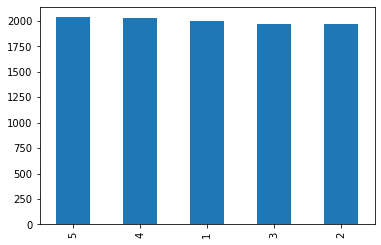

In [4]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand samples for each review score, from 1 to 5.

##### Most frequent Words

c:\Users\monki\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

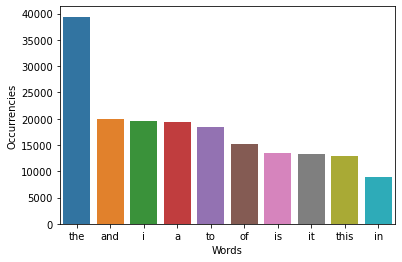

In [5]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [6]:
ps = PorterStemmer()

def normalize(text):
    # remove non alpha chars
    text = re.sub('[^a-zA-Z]', ' ', text)   # TODO: CHECK THIS REGULAR EXPRESSION
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

    return text


train['review_text'] = train['review_text'].apply(normalize)

train['review_title'] = train['review_title'].apply(normalize)
train.head()


test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [7]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

##### Generating wordclouds
A visually appealing way of observing words in a dataset is by showing wordclouds. In order to make a single wordcloud for a whole column, we can join all the cells together. We then pass it to WordCloud to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

These are the most common words in the reviews' titles:

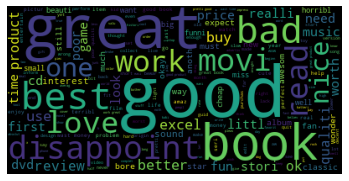

In [8]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()

These are the most common words in the reviews' text:

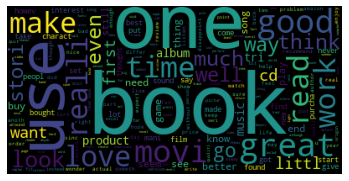

In [9]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the reviews' classes (1 to 5):

Word cloud for class 1's titles:


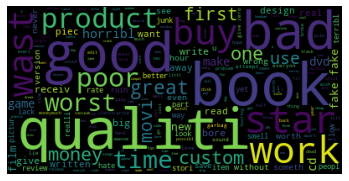

Word cloud for class 1's text:


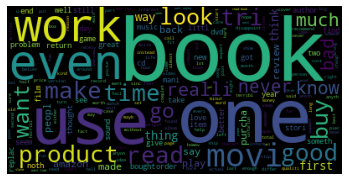

Word cloud for class 2's titles:


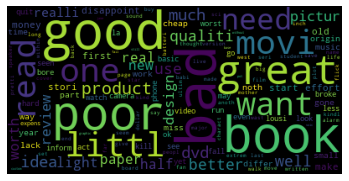

Word cloud for class 2's text:


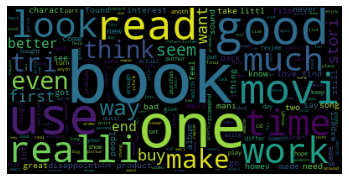

Word cloud for class 3's titles:


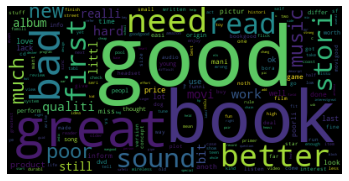

Word cloud for class 3's text:


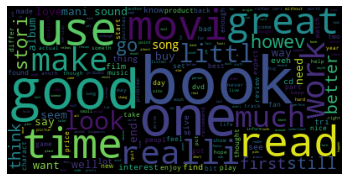

Word cloud for class 4's titles:


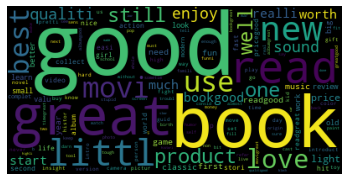

Word cloud for class 4's text:


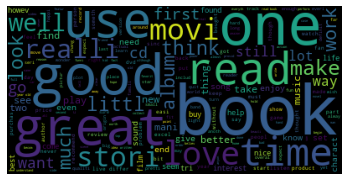

Word cloud for class 5's titles:


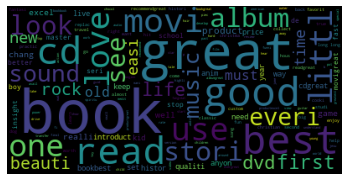

Word cloud for class 5's text:


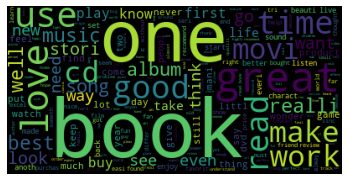

In [10]:
wordsPerClass = {
    1: ("", ""), # title and text
    2: ("", ""),
    3: ("", ""),
    4: ("", ""),
    5: ("", ""),
}

for i in range(len(train)):
    classId = int(train['class_index'].values[i])
    titleWords = train['review_title'].values[i]
    textWords = train['review_text'].values[i]
    
    wordsPerClass[classId] = (wordsPerClass[classId][0] + titleWords, wordsPerClass[classId][1] + textWords)

for i in range(1, 6):
    # Word cloud for class's titles
    wordcloudTitle = WordCloud().generate(wordsPerClass[i][0])
    print(f"Word cloud for class {i}'s titles:")

    plt.figure()
    plt.imshow(wordcloudTitle)
    plt.axis('off')
    plt.show()

    # Word cloud for class's text
    wordcloudText = WordCloud().generate(wordsPerClass[i][1])
    print(f"Word cloud for class {i}'s text:")

    plt.figure()
    plt.imshow(wordcloudText)
    plt.axis('off')
    plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [44]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

titleVectorizer = CountVectorizer()
textVectorizer = CountVectorizer()

trainTitleArr = list(map(str, train['review_title']))
trainTextArr = list(map(str, train['review_text']))

titleWords = titleVectorizer.fit_transform(trainTitleArr).toarray()
textWords = textVectorizer.fit_transform(trainTextArr).toarray()

allWords = np.array([np.concatenate((titleWords[i], textWords[i])) for i in range(len(titleWords))])

print(titleWords.shape)
# print(vectorizer.get_feature_names())
print(textWords.shape)

print(allWords.shape)

(10000, 6313)
(10000, 22915)
(10000, 29228)


### Training Classifiers

In [45]:
y = train['class_index']

clf = MultinomialNB()

# Train with allWords
clf.fit(allWords, y, sample_weight=1)

### Prediction

In [84]:
testTitleArr = list(map(str, test['review_title']))
testTextArr = list(map(str, test['review_text']))

testTitleVector = titleVectorizer.transform(testTitleArr).toarray()
testTextVector = textVectorizer.transform(testTitleArr).toarray()

testAllWords = np.array([np.concatenate((testTitleVector[i], testTextVector[i])) for i in range(len(testTitleVector))])

y_pred = clf.predict(testAllWords)
print(y_pred)

[4 3 4 ... 3 5 5]


### Analyse Results

In [83]:
# confusion matrix
confusionMatrix = confusion_matrix(test['class_index'], y_pred)
print(confusionMatrix)

correctReviews = 0
for i in range(len(confusionMatrix)):
    correctReviews += confusionMatrix[i][i]

incorrectReviews = sum(map(sum, confusionMatrix)) - correctReviews
# print("correctReviews:", correctReviews)
# print("incorrectReviews:", incorrectReviews)

accuracy = (correctReviews / (incorrectReviews + correctReviews)) * 100

# accuracy, precision, recall, f1
# CHECK IF CONFUSION MATRIX IS ORDER FROM 1-5 RATING
print("Accuracy:", accuracy)
for i in range(5):
    colSum = 0
    for j in range(5):
        colSum += confusionMatrix[j][i]
    
    precision = (confusionMatrix[i][i] / colSum)
    recall = (confusionMatrix[i][i] / sum(confusionMatrix[i]))
    fMeasure = (2*precision*recall) / (precision + recall) 
    print("-------\n", i+1, "Rating Results:")
    print("Precision:", precision * 100, "%")
    print("Recall:", recall * 100, "%")
    print("F-measure:", fMeasure * 100, "%")

[[199  79  40  37  49]
 [114 122  75  54  60]
 [ 72  71 120  79  78]
 [ 36  50  83 126 174]
 [ 29  24  39  90 260]]
Accuracy: 38.28703703703704
-------
 1 Rating Results:
Precision: 44.22222222222222 %
Recall: 49.257425742574256 %
F-measure: 46.604215456674474 %
-------
 2 Rating Results:
Precision: 35.26011560693642 %
Recall: 28.705882352941174 %
F-measure: 31.647211413748376 %
-------
 3 Rating Results:
Precision: 33.61344537815126 %
Recall: 28.57142857142857 %
F-measure: 30.888030888030887 %
-------
 4 Rating Results:
Precision: 32.64248704663213 %
Recall: 26.865671641791046 %
F-measure: 29.47368421052632 %
-------
 5 Rating Results:
Precision: 41.86795491143317 %
Recall: 58.82352941176471 %
F-measure: 48.918156161806216 %
